# "Human or Robot" 
## Predicting Auction Fraud

On an auction website, human bidders are becoming increasingly frustrated with their inability to win auctions vs. their software-controlled counterparts. As a result, usage from the site's core customer base is plummeting. In order to rebuild customer happiness, the site owners need to eliminate computer generated bidding from their auctions.

The goal of this project is to identify online auction bids that are placed by "robots", thus helping the site owners easily flag these users for removal from their site to prevent unfair auction activity.

<img src="../images/robots-greeting.png" width="500">

## FEATURE ENGINEERING

- Number of bids per auction by bidder_id
- Number of countries per bidder_id
- Number of IP addresses per bidder_id
- Number of URLs per bidder_id
- Number of same IP addresses per auction for bidder_id
- Difference in bidding time per bidder_id
- Rearrange merchandise to columns and have values as number of bids for each bidder

Considering:
- Create unique bidder_id using time (year)


In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ignore the warning
import warnings
warnings.filterwarnings('ignore')

### 1. Auction Dataset

In [2]:
# load auction_df
auction_df = pd.read_csv('../large_data/auction_df')
auction_df.columns

Index(['bid_id', 'auction', 'merchandise', 'device', 'time', 'country', 'ip',
       'url', 'bidder_id', 'payment_account', 'address', 'outcome'],
      dtype='object')

In [3]:
auction_df.head()

,bid_id,auction,merchandise,device,time,country,ip,url,bidder_id,payment_account,address,outcome
0,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
2,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
3,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
4,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0


In [4]:
# number of unique rows
auction_df.nunique()

bid_id             3071224
auction              12740
merchandise             10
device                5729
time                742669
country                199
ip                 1030950
url                 663873
bidder_id             1984
payment_account       1984
address               1984
outcome                  2
dtype: int64

- Number of unique bidder_id = 1984


Since the auction_df is the dataset used to derive new features at the bidder level. The final dataset must contain 1984 rows.

In [5]:
# check for missing data
auction_df.isnull().sum().sort_values()

bid_id             0
auction            0
merchandise        0
device             0
time               0
country            0
ip                 0
url                0
bidder_id          0
payment_account    0
address            0
outcome            0
dtype: int64

-----

### 2. Train Dataset

In [6]:
# load train df
train = pd.read_csv('../data/train.csv')
train.columns

Index(['bidder_id', 'payment_account', 'address', 'outcome'], dtype='object')

In [7]:
train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [8]:
# number of unique rows
train.nunique()

bidder_id          2013
payment_account    2013
address            2013
outcome               2
dtype: int64

- Number of unique bidder_id = 2013

There are 29 extra bidder_ids in the train dataset, which we will drop later since the new features are being generated for 1984 unique bidder_ids present on the auction_df.

In [9]:
# check for missing data
train.isnull().sum().sort_values()

bidder_id          0
payment_account    0
address            0
outcome            0
dtype: int64

### 3. Feature Engineering

- These features are not at bidder_level but were useful to understand difference in behavior for humans and robots.

In [10]:
# # bidding time difference per user (bidder_id)
# auction_df = auction_df.sort_values(by=['time'])
# auction_df['timediffs'] = auction_df.groupby('bidder_id')['time'].transform(pd.Series.diff)

# # number of bids a user made per auction
# bids_per_auction = auction_df.groupby(['auction', 'bidder_id']).size()
# bids_per_auction = bids_per_auction.to_frame()

# # number of countries per user
# country_per_user = auction_df.groupby(['country', 'bidder_id']).size()
# country_per_user = country_per_user.to_frame()

# # number of device per user
# device_per_user = auction_df.groupby(['device', 'bidder_id']).size()
# device_per_user = device_per_user.to_frame()

# # proportion of bots for each country
# bots_country = auction_df[auction_df['outcome'] == 1].groupby(
#     'country').size()/auction_df.groupby('country').size()
# bots_country = bots_country.fillna(0)
# bots_country = bots_country.to_frame()

# # proportion of bots per device
# bots_device = auction_df[auction_df['outcome'] == 1].groupby(
#     'device').size()/auction_df.groupby('device').size()
# bots_device = bots_device.fillna(0)
# bots_device = bots_device.to_frame()

# # number of bids a user made per device
# bids_per_device = auction_df.groupby(['device', 'bidder_id']).size()
# bids_per_device = bids_per_device.to_frame()

# # number of bids a user made per country
# bids_per_country = auction_df.groupby(['country', 'bidder_id']).size()
# bids_per_country = bids_per_country.to_frame()


In [11]:
# first round feature creation at bidder_level
# proportion of unique ip addresses to bids per user
ip_bids_per_user = auction_df.groupby('bidder_id')['ip'].nunique()/auction_df.groupby('bidder_id')['bid_id'].nunique()
ip_bids_per_user = ip_bids_per_user.to_frame()

# proportion of unique url addresses to bids per user
url_bids_per_user = auction_df.groupby('bidder_id')['url'].nunique()/auction_df.groupby('bidder_id')['bid_id'].nunique()
url_bids_per_user = url_bids_per_user.to_frame()

# number of bids per user
bids_per_user = auction_df.groupby('bidder_id')['bid_id'].size()
bids_per_user = bids_per_user.to_frame()

# total unique URL per user
url_per_user = auction_df.groupby('bidder_id')['url'].nunique()
url_per_user = url_per_user.to_frame()

# total unique auction per user
auction_per_user = auction_df.groupby('bidder_id')['auction'].nunique()
auction_per_user = auction_per_user.to_frame()

# total unique ip per user
ip_per_user = auction_df.groupby('bidder_id')['ip'].nunique()
ip_per_user = ip_per_user.to_frame()

# mean number of bids per user for each auction
avg_bids_per_user = auction_df.groupby(['bidder_id', 'auction'])['bid_id'].count().groupby(
['bidder_id']).mean()
avg_bids_per_user = avg_bids_per_user.to_frame()

# median number of bids per user for each auction
median_bids_per_user = auction_df.groupby(['bidder_id', 'auction'])['bid_id'].count().groupby(
['bidder_id']).median()
median_bids_per_user = median_bids_per_user.to_frame()


In [12]:
# Second round of feature engineering
# mean number of countries per user for each auction
avg_country_per_user = auction_df.groupby(['bidder_id', 'auction'])['country'].nunique().groupby(
['bidder_id']).mean()
avg_country_per_user = avg_country_per_user.to_frame()

# median number of countries per user for each auction
median_country_per_user = auction_df.groupby(['bidder_id', 'auction'])['country'].nunique().groupby(
['bidder_id']).median()
median_country_per_user = median_country_per_user.to_frame()

# mean number of auctions per user for each country
avg_auction_per_country_user = auction_df.groupby(['bidder_id', 'country'])['auction'].count().groupby(
['bidder_id']).mean()
avg_auction_per_country_user = avg_auction_per_country_user.to_frame()

# median number of auctions per user for each country 
median_auction_per_country_user = auction_df.groupby(['bidder_id', 'country'])['auction'].count().groupby(
['bidder_id']).median()
median_auction_per_country_user = median_auction_per_country_user.to_frame()

# mean number of url per device per user
avg_url_per_device_user = auction_df.groupby(['bidder_id', 'device'])['url'].count().groupby(
['bidder_id']).mean()
avg_url_per_device_user = avg_url_per_device_user.to_frame()

# median number of url per device for each user
median_url_per_device_user = auction_df.groupby(['bidder_id', 'device'])['url'].count().groupby(
['bidder_id']).median()
median_url_per_device_user = median_url_per_device_user.to_frame()

# mean number of ip per device for each user
avg_ip_per_device_user = auction_df.groupby(['bidder_id', 'device'])['ip'].count().groupby(
['bidder_id']).mean()
avg_ip_per_device_user = avg_ip_per_device_user.to_frame()

# median number of ip per device for each user
median_ip_per_device_user = auction_df.groupby(['bidder_id', 'device'])['ip'].count().groupby(
['bidder_id']).median()
median_ip_per_device_user = median_ip_per_device_user.to_frame()



In [13]:
# features that won't be used for ml modeling
# train = pd.merge(train, bids_per_auction, on=['bidder_id'], how='left')
# train = pd.merge(train, country_per_user, on='bidder_id', how='left')
# train = pd.merge(train, device_per_user, on='bidder_id', how='left')
# train = pd.merge(train, bots_country, on='country', how='left')
# train = pd.merge(train, bots_device, on='device', how='left')
#train = pd.merge(train, bids_per_device, on=['device', 'bidder_id'], how='left')
#train = pd.merge(train, bids_per_country, on=['country', 'bidder_id'], how='left')

# first round
train = pd.merge(train, ip_bids_per_user, on='bidder_id', how='left')
train = pd.merge(train, url_bids_per_user, on='bidder_id', how='left')
train = pd.merge(train, bids_per_user, on='bidder_id', how='left')
train = pd.merge(train, url_per_user, on='bidder_id', how='left')
train = pd.merge(train, auction_per_user, on='bidder_id', how='left')
train = pd.merge(train, ip_per_user, on='bidder_id', how='left')
train = pd.merge(train, avg_bids_per_user, on='bidder_id', how='left')
train = pd.merge(train, median_bids_per_user, on='bidder_id', how='left')

# second round
train = pd.merge(train, avg_country_per_user, on='bidder_id', how='left')
train = pd.merge(train, median_country_per_user, on='bidder_id', how='left')
train = pd.merge(train, avg_auction_per_country_user, on='bidder_id', how='left')
train = pd.merge(train, median_auction_per_country_user, on='bidder_id', how='left')
train = pd.merge(train, avg_url_per_device_user, on='bidder_id', how='left')
train = pd.merge(train, median_url_per_device_user, on='bidder_id', how='left')
train = pd.merge(train, avg_ip_per_device_user, on='bidder_id', how='left')
train = pd.merge(train, median_ip_per_device_user, on='bidder_id', how='left')


In [14]:
# update column names
train.columns = ['bidder_id', 'payment_account', 'address', 'outcome',
                  'ip_bids_per_user', 'url_bids_per_user', 'bids_per_user', 'url_per_user', 'auction_per_user', 
                  'ip_per_user', 'avg_bids_per_user', 'median_bids_per_user', 'avg_country_per_user', 
                  'median_country_per_user', 'avg_auction_per_country_user', 'median_auction_per_country_user',
                  'avg_url_per_device_user', 'median_url_per_device_user', 'avg_ip_per_device_user', 
                  'median_ip_per_device_user']

print(train.columns)

Index(['bidder_id', 'payment_account', 'address', 'outcome',
       'ip_bids_per_user', 'url_bids_per_user', 'bids_per_user',
       'url_per_user', 'auction_per_user', 'ip_per_user', 'avg_bids_per_user',
       'median_bids_per_user', 'avg_country_per_user',
       'median_country_per_user', 'avg_auction_per_country_user',
       'median_auction_per_country_user', 'avg_url_per_device_user',
       'median_url_per_device_user', 'avg_ip_per_device_user',
       'median_ip_per_device_user'],
      dtype='object')


In [15]:
# check for missing data
train.isnull().sum().sort_values()

bidder_id                           0
payment_account                     0
address                             0
outcome                             0
median_url_per_device_user         29
avg_url_per_device_user            29
median_auction_per_country_user    29
avg_auction_per_country_user       29
median_country_per_user            29
avg_country_per_user               29
median_bids_per_user               29
ip_per_user                        29
avg_ip_per_device_user             29
auction_per_user                   29
url_per_user                       29
bids_per_user                      29
url_bids_per_user                  29
ip_bids_per_user                   29
avg_bids_per_user                  29
median_ip_per_device_user          29
dtype: int64

- There are 29 missing values as expected since there is a mismatch in the number of unique values in the auction_df vs train df. During data wrangling we learned these 29 missing values are classified as human bidders, since we are interested in fnding robot bidders, we're going to go ahead and drop these.


In [16]:
train = train.dropna()
train['bidder_id'].nunique()

1984

In [17]:
train

,bidder_id,payment_account,address,outcome,ip_bids_per_user,url_bids_per_user,bids_per_user,url_per_user,auction_per_user,ip_per_user,avg_bids_per_user,median_bids_per_user,avg_country_per_user,median_country_per_user,avg_auction_per_country_user,median_auction_per_country_user,avg_url_per_device_user,median_url_per_device_user,avg_ip_per_device_user,median_ip_per_device_user
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,0.833333,0.041667,24.0,1.0,18.0,20.0,1.333333,1.0,1.166667,1.0,4.0,2.0,1.714286,1.0,1.714286,1.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1.000000,0.666667,3.0,2.0,1.0,3.0,3.000000,3.0,1.000000,1.0,3.0,3.0,1.500000,1.5,1.500000,1.5
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,1.000000,0.500000,4.0,2.0,4.0,4.0,1.000000,1.0,1.000000,1.0,4.0,4.0,2.000000,2.0,2.000000,2.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,0.793548,0.587097,155.0,91.0,23.0,123.0,6.739130,2.0,1.000000,1.0,77.5,77.5,2.924528,1.0,2.924528,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,369515b3af4f8ca582f90271d30b14b6r52aw,a1f85275793c4a782f0a668711f41b927ivc9,e6882cf204a9482edd042b6e31791dfctxzx8,0.0,0.138889,0.055556,36.0,2.0,25.0,5.0,1.440000,1.0,1.000000,1.0,9.0,4.0,9.000000,1.0,9.000000,1.0
2009,f939c17ffc7c39ac9b35b69e5e75179fv9pe2,a3d2de7675556553a5f08e4c88d2c2286s1m2,b9b03d5a127eb07aeb9163cdcf524e1344ac9,0.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0
2010,c806dbb2decba0ed3c4ff5e2e60a74c2wjvbl,a3d2de7675556553a5f08e4c88d2c22856leq,d02c2b288b8aabd79ff47118aff41a2dqwzwc,0.0,1.000000,0.500000,2.0,1.0,1.0,2.0,2.000000,2.0,1.000000,1.0,2.0,2.0,1.000000,1.0,1.000000,1.0
2011,0381a69b7a061e9ace2798fd48f1f537mgq57,fd87037ce0304077079c749f420f0b4c54uo0,f030a221726fbcdfc4dc7dfd1b381a112hieq,0.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0


### 4. Visualization
Distribution of each new feature for human and robots

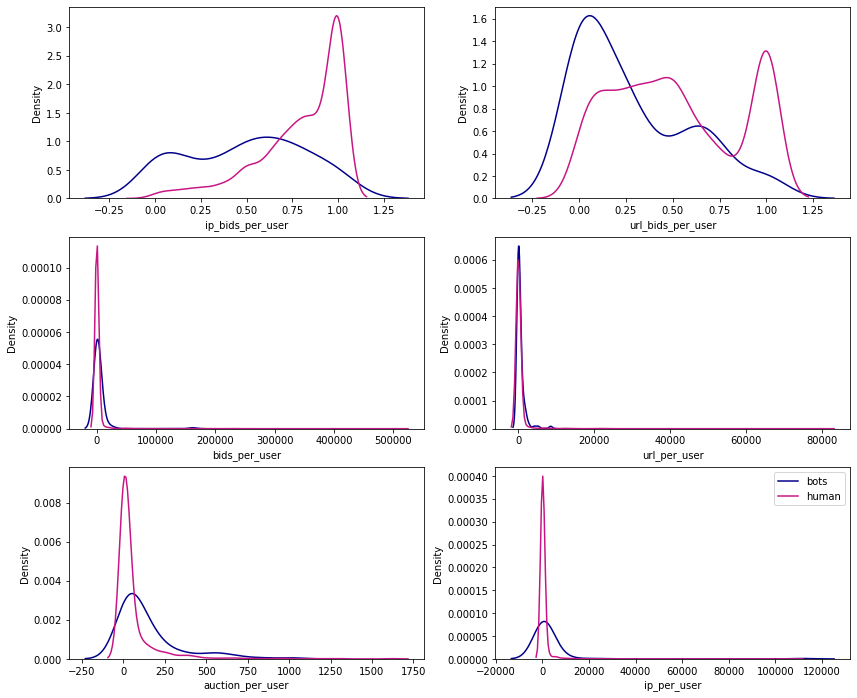

In [18]:
bots = train.loc[train.outcome == 1]
human = train.loc[train.outcome == 0]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=False)

# ip_bids_per_user
sns.distplot(bots['ip_bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])
sns.distplot(human['ip_bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='mediumvioletred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])

# url_bids_per_user
sns.distplot(bots['url_bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])
sns.distplot(human['url_bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='mediumvioletred',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])

# bids_per_user
sns.distplot(bots['bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkblue', label='bots',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])
sns.distplot(human['bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='mediumvioletred', label='human',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])

# url_per_user
sns.distplot(bots['url_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])
sns.distplot(human['url_per_user'], hist=False, kde=True,
             bins=int(180/5), color='mediumvioletred',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])

# auction_per_user
sns.distplot(bots['auction_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])
sns.distplot(human['auction_per_user'], hist=False, kde=True,
             bins=int(180/5), color='mediumvioletred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])

# ip_per_user
sns.distplot(bots['ip_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkblue',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
sns.distplot(human['ip_per_user'], hist=False, kde=True,
             bins=int(180/5), color='mediumvioletred',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])

plt.legend(['bots', 'human'])
plt.show()

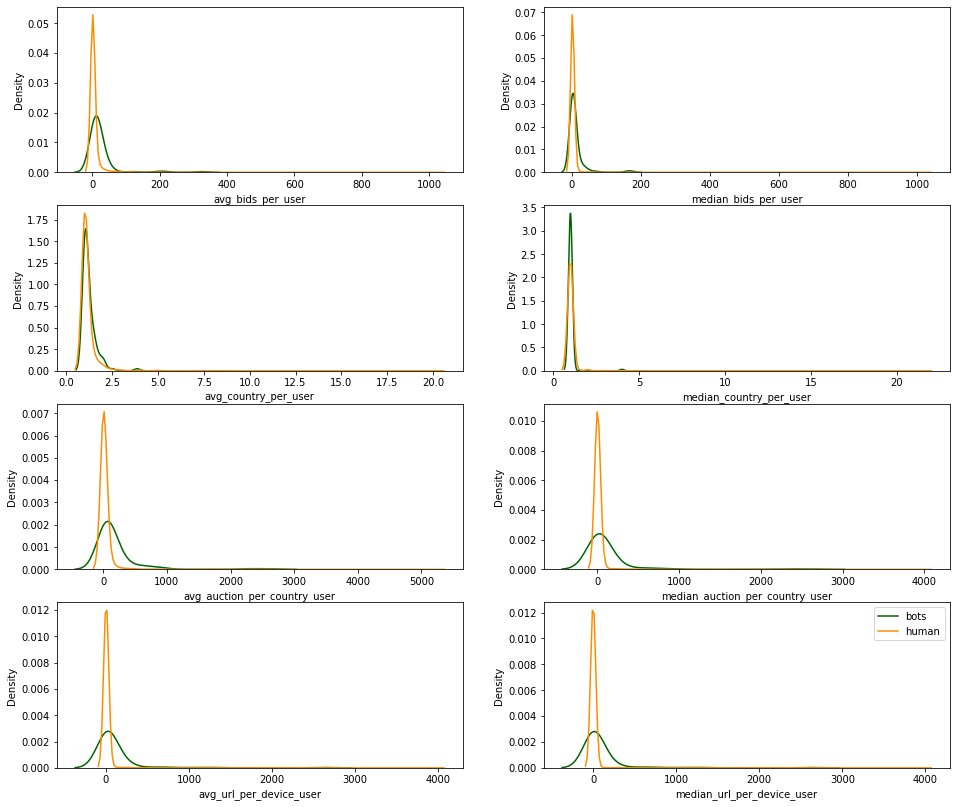

In [19]:
bots = train.loc[train.outcome == 1]
human = train.loc[train.outcome == 0]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 14), sharex=False)

# avg_bids_per_user
sns.distplot(bots['avg_bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkgreen',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])
sns.distplot(human['avg_bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkorange',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 0])

# median_bids_per_user
sns.distplot(bots['median_bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkgreen',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])
sns.distplot(human['median_bids_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkorange',
             kde_kws={'linewidth': 1.5}, ax=axes[0, 1])

# avg_country_per_user
sns.distplot(bots['avg_country_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkgreen', label='bots',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])
sns.distplot(human['avg_country_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkorange', label='human',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 0])

# median_country_per_user
sns.distplot(bots['median_country_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkgreen',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])
sns.distplot(human['median_country_per_user'], hist=False, kde=True,
             bins=int(180/5), color='darkorange',
             kde_kws={'linewidth': 1.5}, ax=axes[1, 1])

# avg_auction_per_country_user
sns.distplot(bots['avg_auction_per_country_user'], hist=False, kde=True,
             bins=int(180/5), color='darkgreen',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])
sns.distplot(human['avg_auction_per_country_user'], hist=False, kde=True,
             bins=int(180/5), color='darkorange',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 0])

# median_auction_per_country_user
sns.distplot(bots['median_auction_per_country_user'], hist=False, kde=True,
             bins=int(180/5), color='darkgreen',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])
sns.distplot(human['median_auction_per_country_user'], hist=False, kde=True,
             bins=int(180/5), color='darkorange',
             kde_kws={'linewidth': 1.5}, ax=axes[2, 1])

# avg_url_per_device_user
sns.distplot(bots['avg_url_per_device_user'], hist=False, kde=True,
             bins=int(180/5), color='darkgreen',
             kde_kws={'linewidth': 1.5}, ax=axes[3, 0])
sns.distplot(human['avg_url_per_device_user'], hist=False, kde=True,
             bins=int(180/5), color='darkorange',
             kde_kws={'linewidth': 1.5}, ax=axes[3, 0])

# median_url_per_device_user
sns.distplot(bots['median_url_per_device_user'], hist=False, kde=True,
             bins=int(180/5), color='darkgreen',
             kde_kws={'linewidth': 1.5}, ax=axes[3, 1])
sns.distplot(human['median_url_per_device_user'], hist=False, kde=True,
             bins=int(180/5), color='darkorange',
             kde_kws={'linewidth': 1.5}, ax=axes[3, 1])

plt.legend(['bots', 'human'])
plt.show()

### 5. Correlation among variables

<AxesSubplot:>

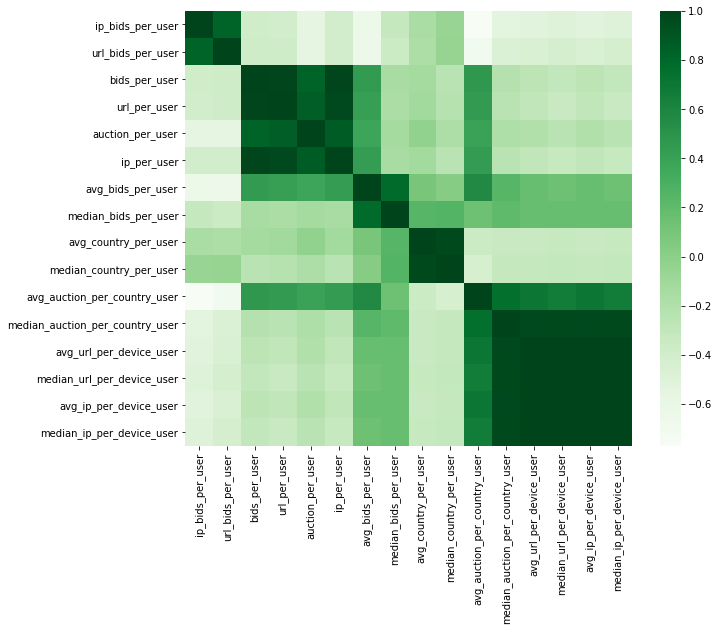

In [20]:
# filter variables of interest
df = train[['ip_bids_per_user', 'url_bids_per_user', 'bids_per_user',
       'url_per_user', 'auction_per_user', 'ip_per_user', 'avg_bids_per_user',
       'median_bids_per_user', 'avg_country_per_user',
       'median_country_per_user', 'avg_auction_per_country_user',
       'median_auction_per_country_user', 'avg_url_per_device_user',
       'median_url_per_device_user', 'avg_ip_per_device_user',
       'median_ip_per_device_user']]

plt.figure(figsize=(10, 8))

# plot the correlation matrix for the numerical values
corr_matrix = df.corr()
sns.heatmap(corr_matrix.corr(),
            xticklabels=corr_matrix.corr().columns,
            yticklabels=corr_matrix.corr().columns,
            cmap="Greens",
            fmt='d')

### 6. Expand merchandise column

In [21]:
# merchandise by user
# rearrange merchandise to columns and have values as number of bids for each bidder
merchandise = auction_df.pivot_table(index='bidder_id', columns='merchandise', 
                 values='bid_id',
                 aggfunc = lambda x: len(x.unique()),
                                    fill_value=0)

merchandise = merchandise.reset_index()
merchandise

merchandise,bidder_id,auto parts,books and music,clothing,computers,furniture,home goods,jewelry,mobile,office equipment,sporting goods
0,001068c415025a009fee375a12cff4fcnht8y,0,0,0,0,0,0,1,0,0,0
1,0030a2dd87ad2733e0873062e4f83954mkj86,0,0,0,0,0,0,0,1,0,0
2,00a0517965f18610417ee784a05f494d4dw6e,0,141,0,0,0,0,0,0,0,0
3,00cc97158e6f4cb8eac3c0075918b7ffi5k8o,0,0,0,0,0,0,0,0,3,0
4,01067975436d123f717ee5aba0dd4bbfa0937,0,0,0,0,0,0,543,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1979,ff92ea4abd33ed38601287f0e1d6726dmgx1f,0,0,0,0,0,0,0,0,0,395
1980,ffacbed056cbfaa60c1fcf51f0d381bddr3ly,0,0,0,0,0,0,0,0,0,9
1981,ffaf0a972a6dcb3910fd6b16045781e2ava5y,0,0,0,0,0,0,0,0,0,3
1982,ffc4e2dd2cc08249f299cab46ecbfacfobmr3,0,0,0,0,0,0,0,22,0,0


In [23]:
# merge auction_df to merchandise
df = pd.merge(train, merchandise, on='bidder_id', how='left')
print(df.columns)

Index(['bidder_id', 'payment_account', 'address', 'outcome',
       'ip_bids_per_user', 'url_bids_per_user', 'bids_per_user',
       'url_per_user', 'auction_per_user', 'ip_per_user', 'avg_bids_per_user',
       'median_bids_per_user', 'avg_country_per_user',
       'median_country_per_user', 'avg_auction_per_country_user',
       'median_auction_per_country_user', 'avg_url_per_device_user',
       'median_url_per_device_user', 'avg_ip_per_device_user',
       'median_ip_per_device_user', 'auto parts', 'books and music',
       'clothing', 'computers', 'furniture', 'home goods', 'jewelry', 'mobile',
       'office equipment', 'sporting goods'],
      dtype='object')


### 7. Drop unique identifier columns

In [24]:
df = df[['outcome',
       'ip_bids_per_user', 'url_bids_per_user', 'bids_per_user',
       'url_per_user', 'auction_per_user', 'ip_per_user', 'avg_bids_per_user',
       'median_bids_per_user', 'avg_country_per_user',
       'median_country_per_user', 'avg_auction_per_country_user',
       'median_auction_per_country_user', 'avg_url_per_device_user',
       'median_url_per_device_user', 'avg_ip_per_device_user',
       'median_ip_per_device_user', 'auto parts', 'books and music',
       'clothing', 'computers', 'furniture', 'home goods', 'jewelry', 'mobile',
       'office equipment', 'sporting goods']]

df.head()

,outcome,ip_bids_per_user,url_bids_per_user,bids_per_user,url_per_user,auction_per_user,ip_per_user,avg_bids_per_user,median_bids_per_user,avg_country_per_user,...,auto parts,books and music,clothing,computers,furniture,home goods,jewelry,mobile,office equipment,sporting goods
0,0.0,0.833333,0.041667,24.0,1.0,18.0,20.0,1.333333,1.0,1.166667,...,0,0,0,0,0,24,0,0,0,0
1,0.0,1.000000,0.666667,3.0,2.0,1.0,3.0,3.000000,3.0,1.000000,...,0,0,0,0,0,0,0,0,3,0
2,0.0,1.000000,0.500000,4.0,2.0,4.0,4.0,1.000000,1.0,1.000000,...,0,0,0,0,0,0,0,0,0,4
3,0.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.793548,0.587097,155.0,91.0,23.0,123.0,6.739130,2.0,1.000000,...,0,0,0,0,0,0,0,0,155,0


In [25]:
#save df to csv
df.to_csv("features-outcome-df", index=False)

-------